In [1]:
import os

import himalaya.scoring
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import BandedRidgeCV, ColumnTransformerNoStack
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.delayer import Delayer

from fmri.features import load_brain_data, load_feature

In [2]:
backend = set_backend("torch_cuda", on_error='throw')
plt.style.use('nord-light-talk')
data_dir = "../../data"

In [3]:
subject = 1
modality = "reading"

In [4]:
n_alphas_batch = 3
n_targets_batch = 100
n_targets_batch_refit = 50

In [5]:
number_of_delays = 4
alphas = np.logspace(-5, 20, 10)
cv = 5

In [6]:
def result_path(subject, modality, ridge_type, param_name, param_range):
    dir = f"results/brain_maps_validation_curves/{modality}/{subject}/{ridge_type}"
    os.makedirs(dir, exist_ok=True)
    path = os.path.join(dir, f"{param_name}_{param_range}.csv")
    return path

# Load features

In [7]:
X_semantic, n_samples_train = load_feature(data_dir, "english1000")
X_low_level, n_samples_train = load_feature(data_dir, "letters")
X = np.concatenate([X_semantic, X_low_level], axis=1)

# Load brain data

In [ ]:
Y, n_samples_train = load_brain_data(data_dir, subject, modality)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])


# Iterations

In [67]:
n_iter_range = np.linspace(1, 100, 10).astype(int)
n_iter_range

array([ 2,  3,  4,  6, 10, 15, 22, 33, 50])

In [69]:
from sklearn.metrics import r2_score

cv_scores = pd.DataFrame()
for _n_iter in n_iter_range:
    print(_n_iter)
    path = result_path(subject, modality, "ridge", "n_iter", _n_iter)
    if not os.path.exists(path):
        print("File does not exist")
        delayer = Delayer(delays=range(1, number_of_delays + 1))
        start_and_end = np.concatenate([[0], np.cumsum([X_semantic.shape[1], X_low_level.shape[1]])])
        slices = [slice(start, end) for start, end in zip(start_and_end[:-1], start_and_end[1:])]
        ct = ColumnTransformerNoStack(transformers=[(f'feature_{i}', delayer, s) for i, s in enumerate(slices)])

        solver_params = dict(
            alphas=alphas, n_iter=_n_iter, n_targets_batch=n_targets_batch,
            n_alphas_batch=n_alphas_batch, n_targets_batch_refit=n_targets_batch_refit,
            score_func=himalaya.scoring.r2_score)
        banded_ridge_cv = BandedRidgeCV(cv=cv, groups="input", solver_params=solver_params)

        pipeline = make_pipeline(
            ct,
            banded_ridge_cv
        )

        pipeline.fit(X[:n_samples_train], Y[:n_samples_train])
        cv_score = pipeline[-1].cv_scores_
        prediction = pipeline.predict(X[n_samples_train:])
        prediction = backend.to_numpy(prediction)
        test_score = r2_score(Y[n_samples_train:], prediction, multioutput='raw_values')
        result = pd.DataFrame(
            {
                'cv_score': cv_score,
                'test_score': test_score
            }
        )
        result.to_csv(path)
        cv_scores = pd.concat([cv_scores, result])
    else:
        print("File exists")
        result = pd.read_csv(path)
        cv_scores = pd.concat([cv_scores, result])

2
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.18 GiB. GPU 0 has a total capacity of 5.92 GiB of which 1.02 GiB is free. Including non-PyTorch memory, this process has 3.23 GiB memory in use. Of the allocated memory 2.95 GiB is allocated by PyTorch, and 164.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0.5, 0, 'CV')

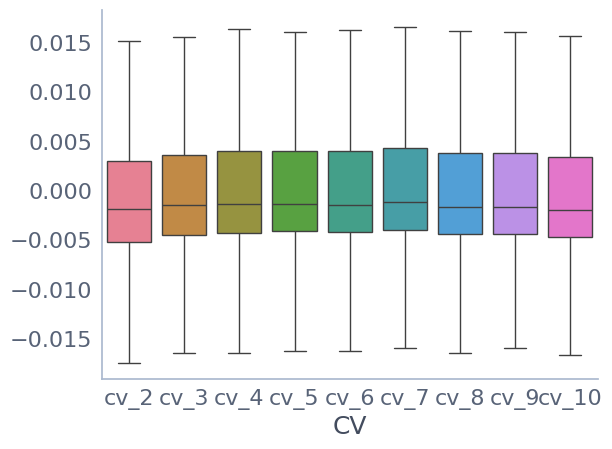

In [26]:
sns.catplot(data=result, kind='box')